In [24]:
from IPython.display import HTML
HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

![title](data/download-google-play-store.png)


# Android App Market Analysis
## Introduction:

The importance of mobile phones in our everyday life and activities is undeniably unending. This is so because there is an ongoing tremendous transformation that mobile phones are no longer the ordinary communication device it used to be. It has become the colossal point of attention for individuals and businesses alike, courtesy of the various incredible features and opportunities that mobile phones offer. The cumulative progress of mobile technology, availability, and access to high-speed internet and the remarkable communicative interface in these devices result in a whole level of new and innovative experience mobile computing. This is made possible through the development of mobile applications (mobile apps).
In this notebook we perform a comprehensive analysis on a dataset that contains 10,000 mobile apps and another data set contains 100 reviews for each app collected from google play store by www.kaggle.com to analyze people's attitude towards mobile apps based on many attributes such as price, category, size, and many other attributes.we start our analysis by data cleaning, making use of the data preprocessing techniques we've learned in the course, then we proceed with analyzing the relations between different attributes in our datasets.

In the following sections we perform the following: 

* Data cleaning
* Exploring app categories 
* App rating distribution 
* Relations between different attributes 
* popularity of paid apps vs free apps 
* Sentiment analysis of user reviews



In [25]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)}) #may remove it later

#may remove it later
# import plotly
# # connected=True means it will download the latest version of plotly javascript library.
# plotly.offline.init_notebook_mode(connected=True)
# import plotly.graph_objs as go

# import plotly.figure_factory as ff
# import cufflinks as cf
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)

import warnings
warnings.filterwarnings('ignore')

## A sneak peek on our dataset
Reading the dataset and showing a random sample of it.

In [26]:
np.random.seed(14)

df = pd.read_csv('../android-app-market-analysis/data/googleplaystore.csv')

df.sample(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
9382,ZOMBIE RIPPER,GAME,3.7,16073,94M,"500,000+",Free,0,Mature 17+,Action,"November 14, 2017",1.4,4.0 and up
2737,Extreme Coupon Finder,SHOPPING,4.1,11798,Varies with device,"1,000,000+",Free,0,Everyone,Shopping,"May 10, 2018",Varies with device,Varies with device
7351,tutti.ch - Free Classifieds,SHOPPING,4.4,9950,15M,"500,000+",Free,0,Everyone,Shopping,"July 18, 2018",3.7.1,4.1 and up
8634,File Viewer for Android,TOOLS,4.1,7063,Varies with device,"1,000,000+",Free,0,Everyone,Tools,"January 25, 2018",2.3.2,5.0 and up
4383,Hands 'n Guns Simulator,FAMILY,3.9,19727,76M,"1,000,000+",Free,0,Teen,Simulation,"July 3, 2018",32,4.1 and up


## Handling Missing Values

In [27]:
print('Number of apps in the dataset : ' , len(df), '\n')
df.drop_duplicates(subset='App', inplace=True)
print('Number of apps in the dataset after removing duplicates: ' , len(df),'\n')

# get the number of missing data points per column
print("Numer of missing values per column:")
missing_values_count = df.isnull().sum()
print(missing_values_count)

Number of apps in the dataset :  10841 

Number of apps in the dataset after removing duplicates:  9660 

Numer of missing values per column:
App                  0
Category             0
Rating            1463
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64


### Precenatge of missing cells:

In [28]:
# How many total missing values do we have?
total_cells = df.size
total_missing = missing_values_count.sum()

# percent of data that is missing
percentage_missign_values = (total_missing/total_cells) * 100
print(percentage_missign_values, '%')

1.175346392737697 %


Since this percentage (1.175346392737697 %) is to small we can safely drop null values without the need to do Imputation.

### Exploring the values in each column and their count to see if further cleaning is required for these values.

In [29]:
for column in df.columns:
    print(df[column].value_counts())

Galaxies of Hope                                  1
CB Frequencies                                    1
The Noise-O-Meter                                 1
Lunar Calendar Lite                               1
Instabridge - Free WiFi Passwords and Hotspots    1
                                                 ..
Al Quran : EAlim - Translations & MP3 Offline     1
TV Guide BR Gold                                  1
HD Wallpaper - Toyota FJ Cruiser                  1
Arrowhead AH App                                  1
BuzzFeed: News, Tasty, Quizzes                    1
Name: App, Length: 9660, dtype: int64
FAMILY       1832
GAME          959
TOOLS         827
BUSINESS      420
MEDICAL       395
             ... 
EVENTS         64
PARENTING      60
COMICS         56
BEAUTY         53
1.9             1
Name: Category, Length: 34, dtype: int64
4.3     897
4.4     895
4.5     848
4.2     810
4.6     683
       ... 
1.6       4
1.4       3
1.5       3
1.2       1
19.0      1
Name: Rating, Lengt

Remove wrong values and type cast the string values into numerical values after removing extras in the strings to use it while exploring  the relations between the attributes.

In [30]:
# Column: Installs -> Remove Wrong Values ('Free'), remove + and , then typecast it to float
                
df = df[df['Installs'] != 'Free']
df['Installs'] = df['Installs'].apply(lambda x: x.replace('+', '') if '+' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: x.replace(',', '') if ',' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: float(x))
print(type(df['Installs'][0]))

<class 'numpy.float64'>


In [31]:
# Column: Size -> Remove 'M', Replace 'k' and divide by 1000 (1MB = 1000 KB)

df['Size'] = df['Size'].apply(lambda x: str(x).replace('Varies with device', 'NaN'))

df['Size'] = df['Size'].apply(lambda x: str(x).replace('M', ''))
df['Size'] = df['Size'].apply(lambda x: str(x).replace(',', ''))
df['Size'] = df['Size'].apply(lambda x: float(str(x).replace('k', '')) / 1000 if 'k' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: float(x))

# Column: Price -> Remove '$' sign
df['Price'] = df['Price'].apply(lambda x: float(str(x).replace('$', '')))

df['Reviews'] = df['Reviews'].apply(lambda x: int(x))

# Column: Last_Updated 
df["Last Updated"] = pd.to_datetime(df['Last Updated'])

print(df.dtypes)

App                       object
Category                  object
Rating                   float64
Reviews                    int64
Size                     float64
Installs                 float64
Type                      object
Price                    float64
Content Rating            object
Genres                    object
Last Updated      datetime64[ns]
Current Ver               object
Android Ver               object
dtype: object


## Exploratory Data Analysis
After data cleaning, we perform a pair plot to examine the relation between each pair of attributes in our dataset.

From this scatter plot we can infere the following: 
 * Free apps have more installations.
 * the higher the rate of the app, the more intstalls and it doesn't matter if the app is paid or not.
 * the majority of apps rating is between  4 and 5.
 

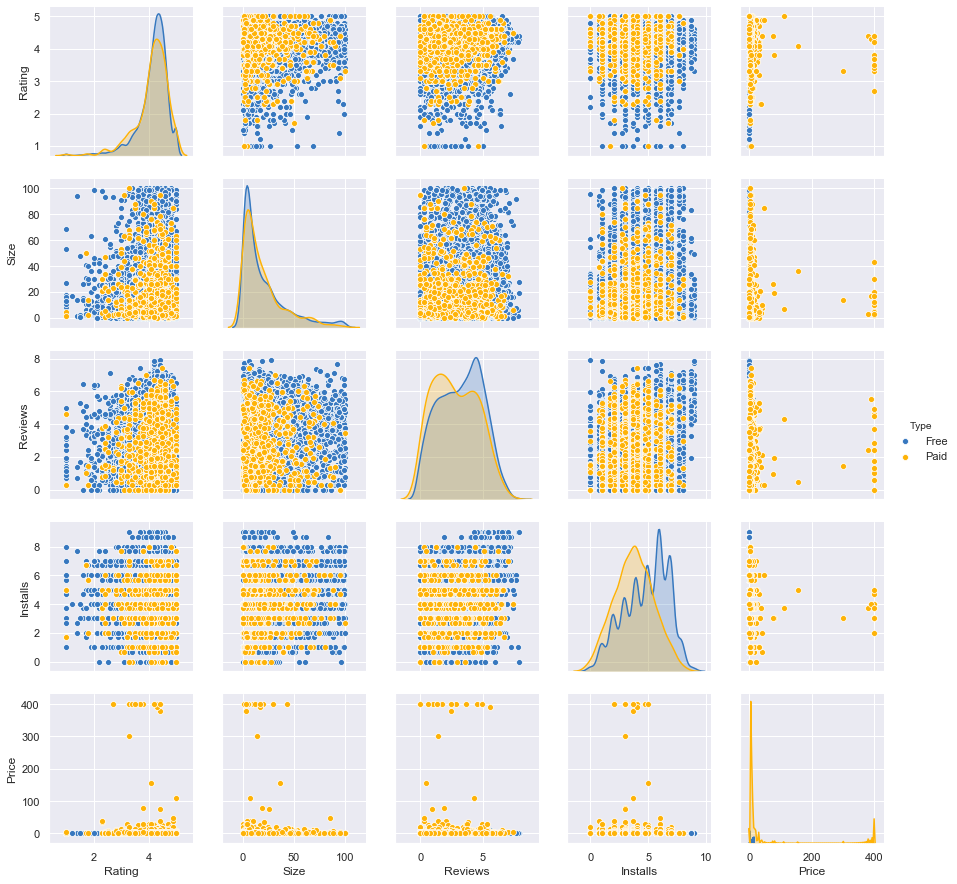

In [32]:
rating = df['Rating'].dropna()
size = df['Size'].dropna()
installs = np.log10(df['Installs'][df.Installs!=0].dropna()) #eliminate zeros f *or computing log
reviews = np.log10(df['Reviews'][df.Reviews!=0].dropna()) #eliminate zeros for computing log
app_type = df['Type'].dropna()
price = df['Price']

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
p = sns.pairplot(pd.DataFrame(list(zip(rating, size, reviews, installs, app_type, price)), 
                        columns=['Rating','Size', 'Reviews', 'Installs', 'Type', 'Price']), hue='Type', palette=sns.xkcd_palette(colors))

### Exploring the number of apps per category 

The graph shows that family apps are the most ones to exist on the app store.

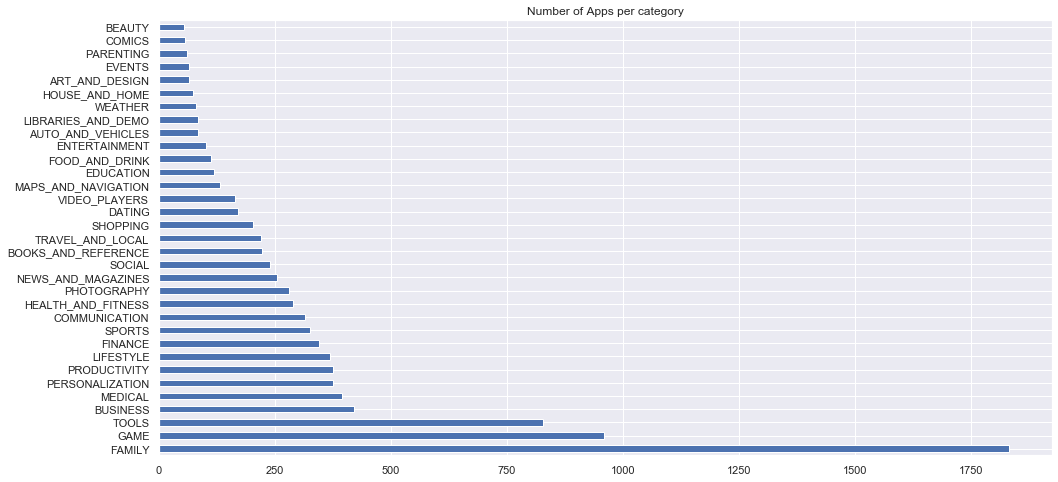

In [33]:
df['Category'].value_counts().plot(kind='barh',figsize= (16,8))
title=plt.title('Number of Apps per category')

### Inspecting the number of installations per each category 
One can see that despite Games are not the most apps to exist on the store, they're the most apps to be installed.

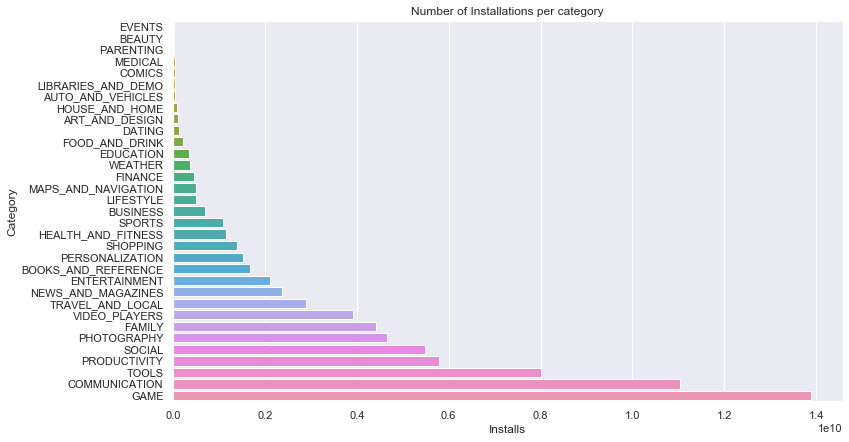

In [34]:
fig = plt.figure(figsize=(12,7))
title=plt.title('Number of Installations per category')
result = df.groupby(["Category"])['Installs'].aggregate(np.sum).reset_index().sort_values('Installs')
bar=sns.barplot(y='Category',x='Installs', data=result, ci=None, order=result['Category'])
plt.show(bar)

### App rating distribution
The histogram shows that most app ratings are pretty high.
the average app rating is 4.17

Average app rating =  4.173243045387994


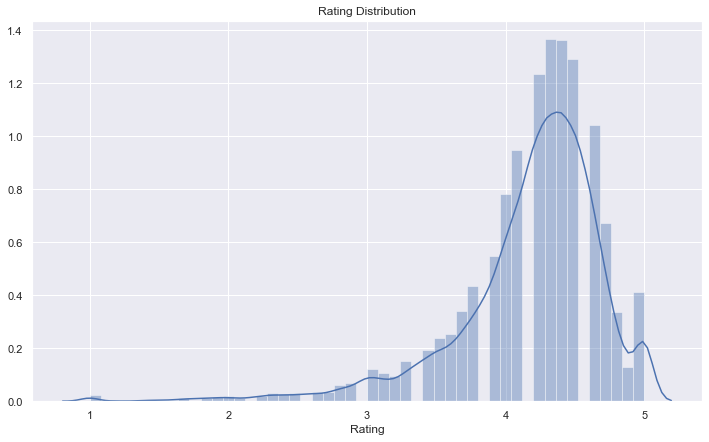

In [35]:
ig = plt.figure(figsize=(12,7))
title=plt.title('Rating Distribution')
hist=sns.distplot(df.Rating.dropna(),kde=True)
print('Average app rating = ', np.mean(df.Rating))
plt.show(hist)

### How different Categories are rated ?
A box plot graph is used here to analyse the ratings per category.

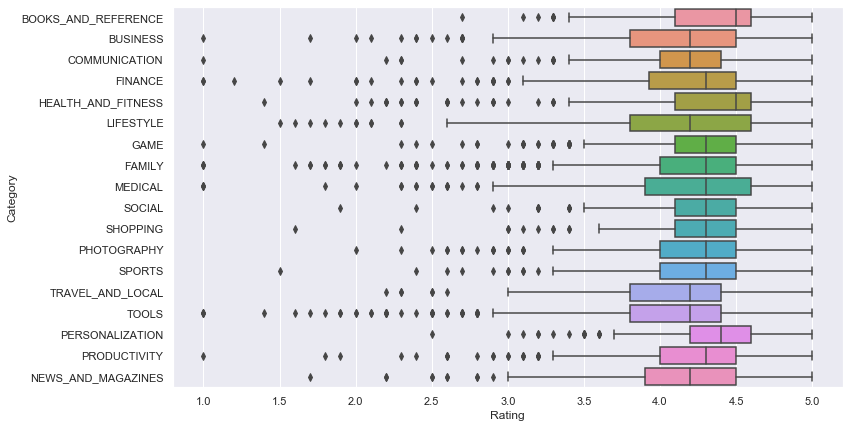

In [36]:
fig = plt.figure(figsize=(12,7))
cat_rate = df.groupby("Category").filter(lambda x: len(x) > 200)
bar = sns.boxplot(x="Rating", y="Category", data=cat_rate)
plt.show(bar)

### Does the size of an apllication affect its rating ?
We use a joint plot here to analyse the relation between the size of an app and its ratings. The graph shows that most applications lie in the low-size high-rating area.

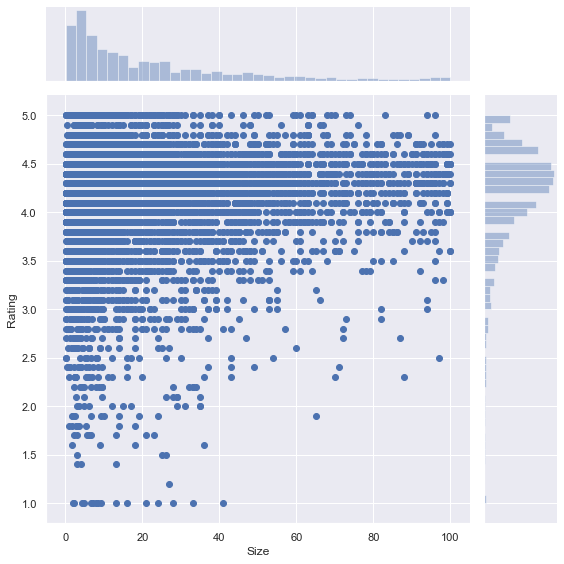

In [37]:
plot = sns.jointplot(df.Size, df.Rating,size=8)

### How does the pricing policy affect the rating of an application ?
The graph shows that top-rated apps are mostly free or low-priced.

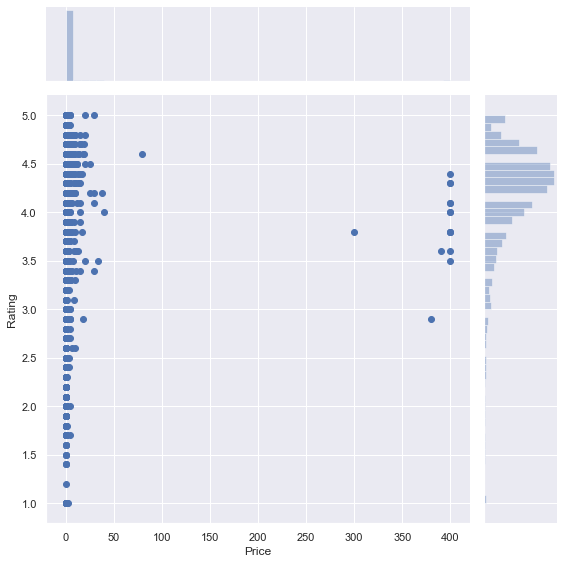

In [38]:
plot = sns.jointplot(df.Price, df.Rating,size=8)

### How different app categories are priced 
The following graph shows the relation between different categories and the application price. We can see that specific categories, such as art and design, or house and home, tend to have lower prices, while other categories such as game, family, and medical, tend to have higher prices.

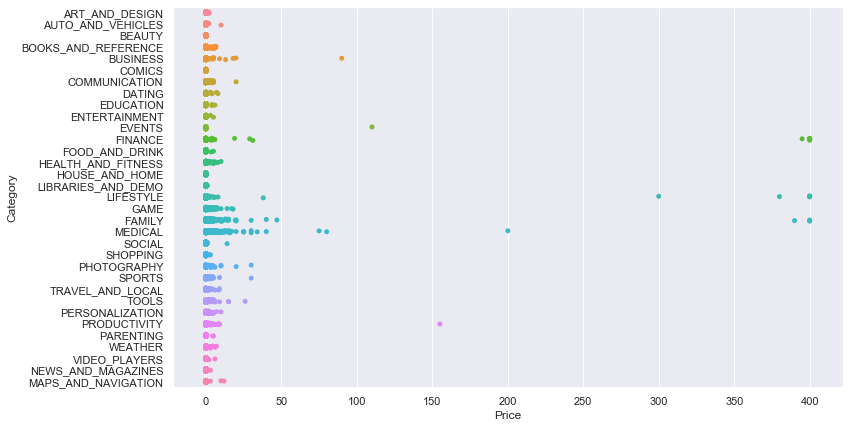

In [39]:

fig = plt.figure(figsize=(12,7))
result = df.groupby(["Category"])['Price'].aggregate(np.mean).reset_index().sort_values('Price')
# bar=sns.barplot(y='Category',x='Price', data=result, ci=None, order=result['Category'])
bar=sns.stripplot(y='Category',x='Price', data=df)
plt.show(bar)

### Average price per category
We analyse the average prices of each category in the following graph. We can see that on average Finance applications tend to have the highest price

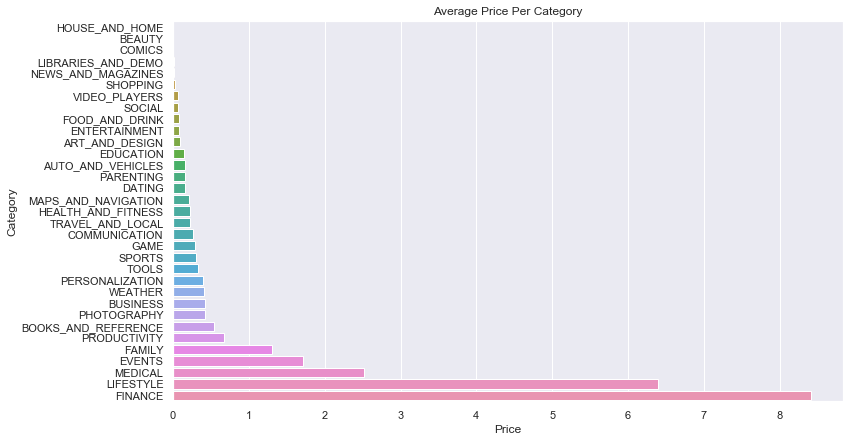

In [40]:
fig = plt.figure(figsize=(12,7))
title=plt.title('Average Price Per Category')
result = df.groupby(["Category"])['Price'].aggregate(np.mean).reset_index().sort_values('Price')
bar=sns.barplot(y='Category',x='Price', data=result, ci=None, order=result['Category'])
plt.show(bar)

### How app sizes vary between different categories  
We analyse the average application size per category. As the graph shows, on average, games tend to have the highest application size among the other categories.

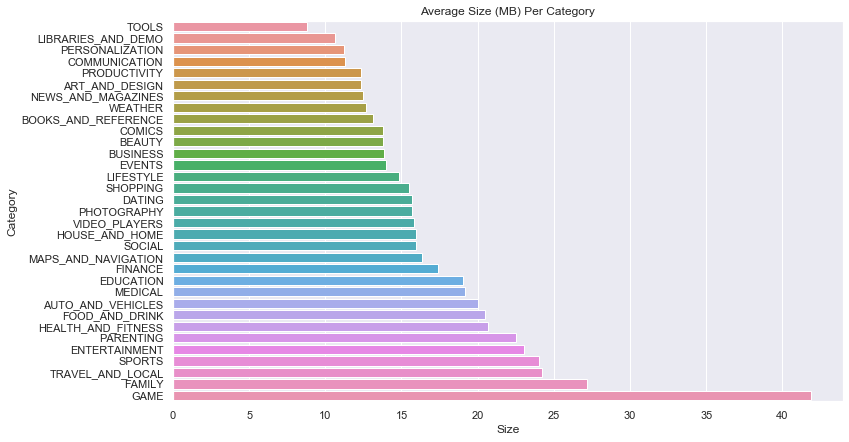

In [41]:
fig = plt.figure(figsize=(12,7))
title=plt.title('Average Size (MB) Per Category')
result = df.groupby(["Category"])['Size'].aggregate(np.mean).reset_index().sort_values('Size')
bar=sns.barplot(y='Category',x='Size', data=result, ci=None, order=result['Category'])
plt.show(bar)

## 400$ Apps ?  
The following table shows the most expensive apps in the dataset. One can easily see that most of them are junk apps that should be removed from that dataset.

In [44]:
df[['Category', 'App','Price']][df.Price > 200]

,Category,App,Price
4197,FAMILY,most expensive app (H),399.99
4362,LIFESTYLE,💎 I'm rich,399.99
4367,LIFESTYLE,I'm Rich - Trump Edition,400.00
5351,LIFESTYLE,I am rich,399.99
5354,FAMILY,I am Rich Plus,399.99
5355,LIFESTYLE,I am rich VIP,299.99
5356,FINANCE,I Am Rich Premium,399.99
5357,LIFESTYLE,I am extremely Rich,379.99
5358,FINANCE,I am Rich!,399.99
5359,FINANCE,I am rich(premium),399.99


In [ ]:
TODO

In [21]:
df = df[df.Price < 100]

## Free or Paid ?
We analyse the percentage of free vs paid apps. As the graph below shows, paid apps represent only 8% of the applications, while free apps represent 92% of the applications

TODO: turn to histogram?

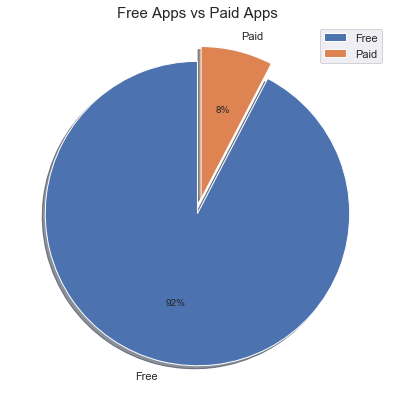

In [18]:
fig = plt.figure(figsize = (7,7))
labels = ['Free', 'Paid'] 
size = df['Type'].value_counts()
explode = [0, 0.1]

plt.pie(size, labels = labels, explode = explode, shadow = True, startangle = 90, autopct='%1.0f%%')
plt.title('Free Apps vs Paid Apps', fontsize = 15)
plt.legend()
plt.show()

## Who has the most Installations 
We analyse the number of installations according to whether an application is free or paid. The vertical axis is log-scaled. As the graph shows, free apps have more installations than paid apps.

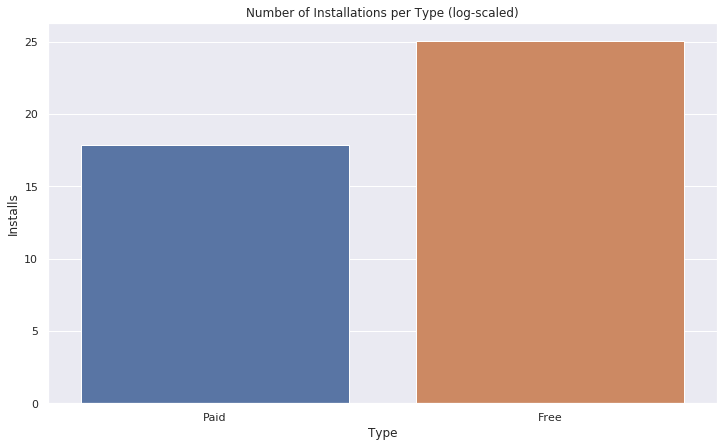

In [70]:
fig = plt.figure(figsize=(12,7))
title=plt.title('Number of Installations per Type (log-scaled)')
result = df.groupby(["Type"])['Installs'].aggregate(np.sum).reset_index().sort_values('Installs')
bar=sns.barplot(x='Type',y=np.log(result.Installs), data=result, ci=None, order=result['Type'])
plt.show(bar)

## Rating vs payment-policy
As the graph shows, the average ratings for both free and paid apps tend to be very close to each other.

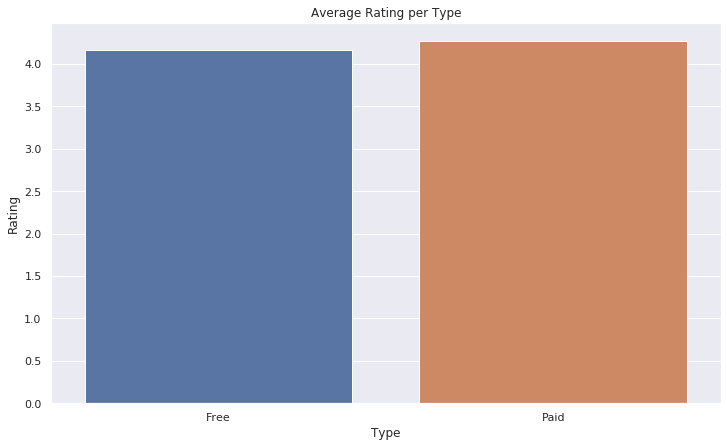

In [71]:
fig = plt.figure(figsize=(12,7))
title=plt.title('Average Rating per Type')
result = df.groupby(["Type"])['Rating'].aggregate(np.mean).reset_index().sort_values('Rating')
bar=sns.barplot(x='Type',y=result.Rating, data=result, ci=None, order=result['Type'])
plt.show(bar)

We analyse the installation per ratings. We draw two lines indicating whether the application is free or paid

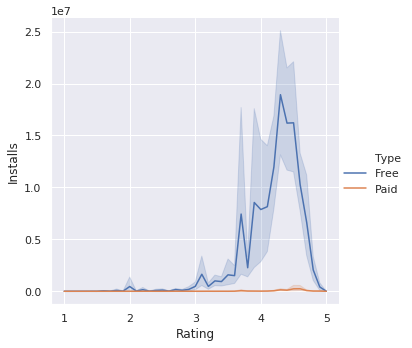

In [72]:
sns.relplot(x="Rating", y="Installs", hue = 'Type' , kind = 'line' , data=df)

## Feature Correlation
We draw a heatmap to analyse the correlation between different attributes. We examined rating, reviews, size, installs, and price, and analysed the correlation between them. Reviews and installs show high correlation while other parameters show fairly low correlation.

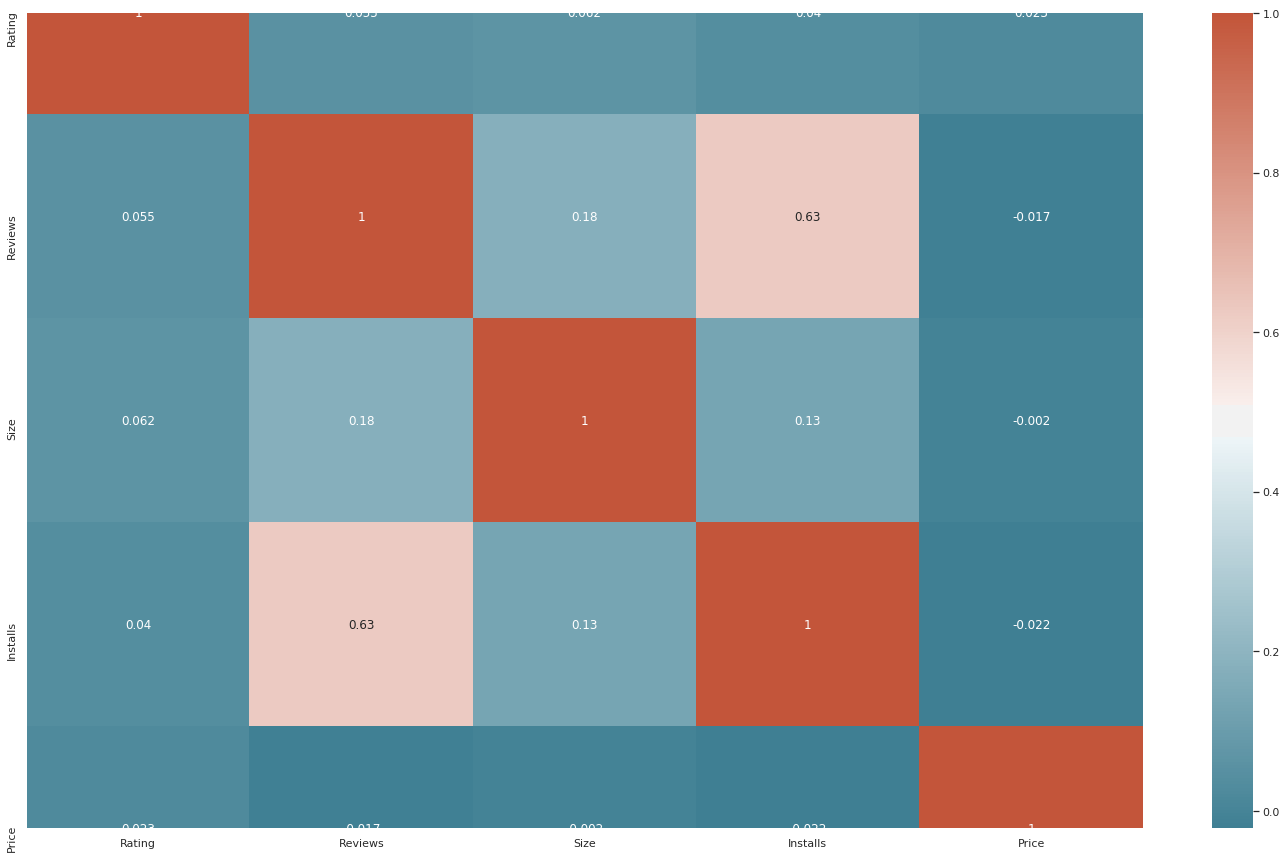

In [73]:
corr_mat = df.corr()
sns.heatmap(corr_mat, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

## Sentiment Analyis for user reviews
At this stage we analyse the user reviews dataset

In [45]:
reviews_df = pd.read_csv('../android-app-market-analysis/data/googleplaystore_user_reviews.csv')
merged_df = pd.merge(df, reviews_df, on = "App", how = "inner")
merged_df = merged_df.dropna(subset=['Sentiment', 'Translated_Review'])

Using box plot graphs, we analyse the different sentiment polarity between different applications categorising them according to free and paid categories

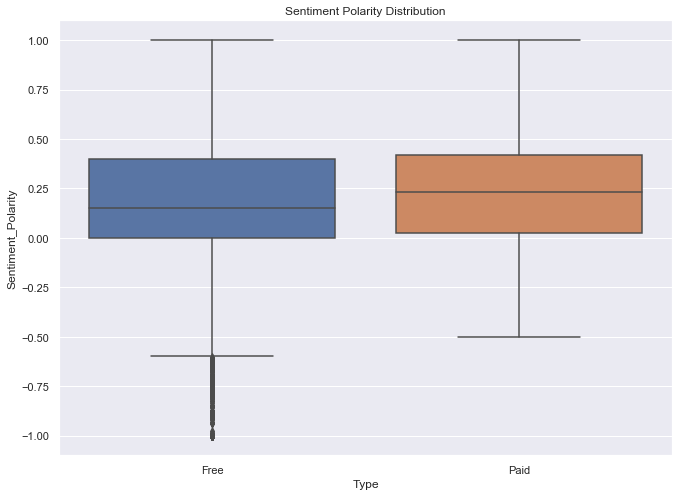

In [46]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)
ax = sns.boxplot(x='Type', y='Sentiment_Polarity', data=merged_df)
title = ax.set_title('Sentiment Polarity Distribution')

We attempt to generate a word cloud to analyse the frequency of words in the reviews. We eliminate stop words from the reviews, as well as invalid reviews. We remove all the dots to be able to split the reviews into words correctly

In [63]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", max_words=500, colormap="Set2")
# generate word cloud

from nltk.corpus import stopwords
stop = stopwords.words('english')
stop = stop + ['app', 'APP' ,'ap', 'App', 'apps', 'application', 'browser', 'website', 'websites', 'chrome', 'click', 'web', 'ip', 'address',
            'files', 'android', 'browse', 'service', 'use', 'one', 'download', 'email', 'Launcher']

merged_df['Translated_Review'] = merged_df['Translated_Review'].apply(lambda x: " ".join(x for x in str(x).split(' ') if x not in stop))
merged_df.Translated_Review = merged_df.Translated_Review.apply(lambda x: x.replace('.', ''))
merged_df.Translated_Review = merged_df.Translated_Review.apply(lambda x: x if 'app' not in x.split(' ') else np.nan)
merged_df.dropna(subset=['Translated_Review'], inplace=True)

We then create a word cloud to analyse the most common words in reviews on free apps

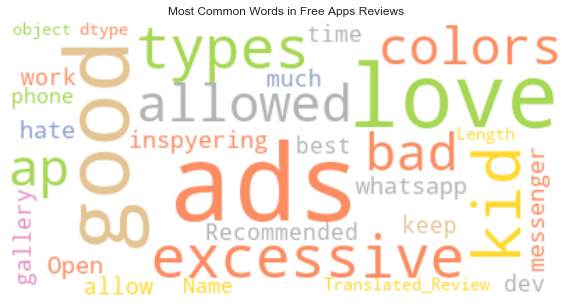

In [64]:
free = merged_df.loc[merged_df.Type=='Free']['Translated_Review'].apply(lambda x: '' if x=='nan' else x)
wc.generate(''.join(str(free)))
plt.figure(figsize=(10, 15))
plt.title('Most Common Words in Free Apps Reviews')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

And we also generate a word cloud to indicate the most common words in reviews on paid apps

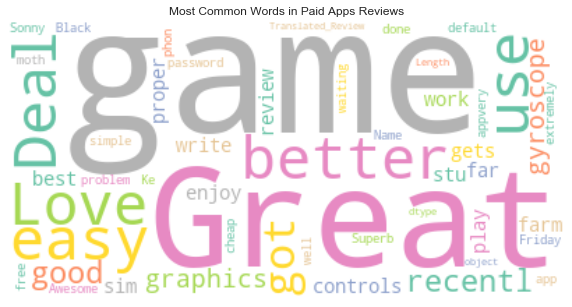

In [65]:
paid = merged_df.loc[merged_df.Type=='Paid']['Translated_Review'].apply(lambda x: '' if x=='nan' else x)
wc.generate(''.join(str(paid)))
plt.figure(figsize=(10, 15))
plt.title('Most Common Words in Paid Apps Reviews')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()